# Tropical Cyclone Kernel Resampler (Tracker)
Tracker is an experimental Python package allowing the user to simulate synthetic Tropical Cyclone (TC) tracks using a simple statistical model fitted to historic IBTrACS data. The method is similar to various autoregressive track simulation algorithms in the literature, but is arguably simpler since it makes very few parametric assumptions, most of which can be changed. The core idea is to create a coarse grid over the ocean and for each cell use Kernel Density Estimation (KDE) to model the joint distribution of latitude, longitude and central pressure at times $t-1$, $t$ and $t+1$. Given values of latitude, longitude and central pressure at times $t-1$ and $t$, the simulation algorithm takes a conditional sample of the values at time $t+1$ from the 'current' (time $t$) cell KDE model.

Some additional features:
- Includes Sea Surface Temperature (SST) at the current grid cell as an additional predictor; a function is included to download ERSSTv5 SST data from NOAA
- Includes a monthly ENSO feature as a predictor; either ONI or RONI, downloaded from NOAA, can be used

Having ENSO and SST as predictors allows some interesting experiments to be performed:
- simple counterfactual analysis - re-run ensembles for historical years under different ENSO or SST states
- stochastic set generation - when combined with a TC genesis model, this track model can be used to generate a stochastic track set. A future refinement could be to add on a simple wind field model, based on the modelled central pressure
- seasonal forecast stochastic set - when combined with a genesis forecast model and seasonal forecasts of SSTs, the model can be used to generate a dynamic stochastic set, conditional on the forecast SSTs, turning predicted basin counts into landfalling frequencies

Potential future refinements:
- Add Z500 field (geopotential height at 500 hPa) as a predictor - can try to use it to estimate steering winds
- Add vertical wind shear field

Note that as the dimensionality of the joint distribution increases, reliable KDE fitting becomes more difficult, and dimensional reduction techniques may need to be introduced.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tracker import Tracker, ERSSTv5

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

### Use the model to download historic TC, SST and ENSO data

Instantiate `Tracker` object:

In [2]:
tr = Tracker()

Examine various default attributes:

In [3]:
tr.basins

['EP', 'NA', 'NI', 'SA', 'SI', 'SP', 'WP']

In [4]:
tr.basin_bounds

{'NA': {'lon_bnds': [-110, 10], 'lat_bnds': [0, 60]},
 'WP': {'lon_bnds': [80, 180], 'lat_bnds': [0, 60]},
 'NI': {'lon_bnds': [45, 160], 'lat_bnds': [0, 60]},
 'SI': {'lon_bnds': [25, 180], 'lat_bnds': [0, -60]},
 'EP': {'lon_bnds': [-180, -50], 'lat_bnds': [0, 60]},
 'SP': {'lon_bnds': [100, 180], 'lat_bnds': [0, -60]},
 'SA': {'lon_bnds': [-50, -30], 'lat_bnds': [0, -60]}}

In [5]:
tr.agencies

['WMO',
 'USA',
 'TOKYO',
 'CMA',
 'HKO',
 'KMA',
 'NEWDELHI',
 'REUNION',
 'BOM',
 'NADI',
 'WELLINGTON']

Agency map specifies which pressure field to use for each basin.

In [6]:
tr.agency_map

{'NA': 'USA',
 'WP': 'TOKYO',
 'NI': 'NEWDELHI',
 'SI': 'BOM',
 'SP': 'BOM',
 'EP': 'USA',
 'SA': 'WMO'}

Use the object to download the latest versions of various datasets:

In [7]:
#for basin in tr.basins:
#    tr.get_ibtracs(basin, tr.agency_map[basin])

Download the latest ENSO indices:

In [8]:
#tr.get_oni()
#tr.get_roni()

Since SSTs take longer to download, we only show the code used to download them, but use data downloaded previously:

In [9]:
#ersstv5 = ERSSTv5()
#ersstv5.download('../data/ersstv5/', year_range=(1950, 2024))

Load the previously-downloaded data from disk:

In [10]:
for basin in tr.basins:
    tr.load_ibtracs(basin, tr.agency_map[basin])
tr.load_SSTs(year_range=(1950, 2024))
tr.load_roni()

  0%|          | 0/900 [00:00<?, ?it/s]

### Preprocess data

Having loaded the data, assemble the design matrix used to fit the models:

In [11]:
Xs = {}
for basin in ['NA','WP']:
    Xs[basin] = tr.make_design_matrix(basin, (1950,2024))

Xs['NA']

  0%|          | 0/1180 [00:00<?, ?it/s]

  0%|          | 0/2632 [00:00<?, ?it/s]

,roni,sst,LON-1,LAT-1,USA_PRES-1,LON,LAT,USA_PRES,LON+1,LAT+1,USA_PRES+1
0,-0.419852,27.884874,-63.2,22.0,997.0,-63.5,22.4,996.0,-63.8,22.7,995.0
1,-0.420056,27.884811,-63.5,22.4,996.0,-63.8,22.7,995.0,-64.2,22.9,995.0
2,-0.420083,27.884993,-63.8,22.7,995.0,-64.2,22.9,995.0,-64.6,23.1,995.0
3,-0.420034,28.036454,-64.2,22.9,995.0,-64.6,23.1,995.0,-65.0,23.2,995.0
4,-0.419857,28.036464,-64.6,23.1,995.0,-65.0,23.2,995.0,-65.4,23.4,995.0
...,...,...,...,...,...,...,...,...,...,...,...
31633,-0.810120,-0.000131,-87.1,16.4,1000.0,-87.3,16.4,1001.0,-87.5,16.5,1001.0
31634,-0.809922,0.000042,-87.3,16.4,1001.0,-87.5,16.5,1001.0,-87.6,16.6,1001.0
31635,-0.810011,0.000040,-87.5,16.5,1001.0,-87.6,16.6,1001.0,-87.9,16.8,1001.0
31636,-0.809927,-0.000150,-88.5,17.1,1001.0,-89.1,17.4,1003.0,-89.7,17.7,1004.0


### Fit KDE autoregressive models

Now fit one basin's KDE models:

In [12]:
basin = 'NA'
_ = tr.fit(Xs[basin], basin=basin)

  0%|          | 0/800 [00:00<?, ?it/s]

Visualise the grid - green cells have fitted models, red cells are those for which no models have been fit due to insufficient data:

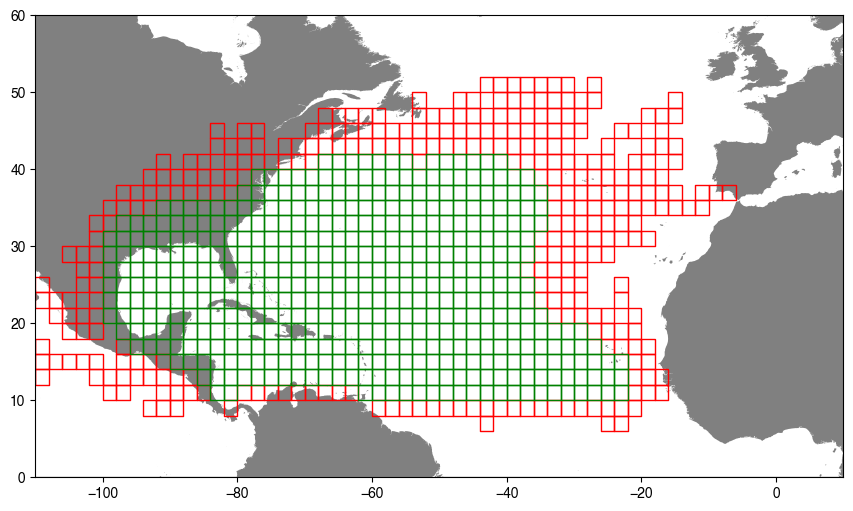

In [13]:
fig = tr.plot_grid(figsize=(12,6))

### Generate synthetic tracks

#### Resimulate a historic track

Choose a historic hurricane in a basin and get its `SID`:

In [14]:
tr.ibtracs[basin][(tr.ibtracs[basin]['NAME']=='ANDREW')&(tr.ibtracs[basin]['year']==1992)].head(2)

,SID,SEASON,NAME,ISO_TIME,NATURE,LAT,LON,USA_PRES,qid,year,month
94491,1992230N11325,1992,ANDREW,1992-08-16 18:00:00,TS,10.8,-35.5,1010.0,32461,1992,8
94492,1992230N11325,1992,ANDREW,1992-08-16 21:00:00,TS,11.0,-36.4,1010.0,32456,1992,8


Resimulate tracks and plot:

  0%|          | 0/318 [00:00<?, ?it/s]

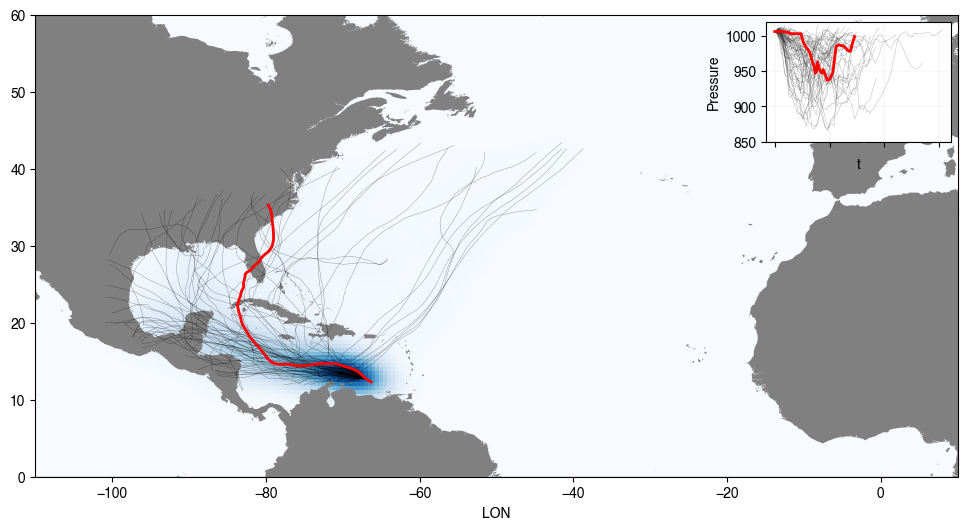

In [15]:
sid, year, month, m = '2022266N12294', 1992, 8, 100
tracks_df = tr.resimulate(sid, basin, m=m)
fig = tr.plot_tracks(tracks_df, basin, sid=sid, figsize=(12,6))

What was the ENSO state?

In [16]:
tr.roni[(tr.roni['year']==year)&(tr.roni['month']==month)]

,year,month,roni
510,1992,8,0.54


#### Resimulate under a strong El Nino counterfactual

  0%|          | 0/318 [00:00<?, ?it/s]

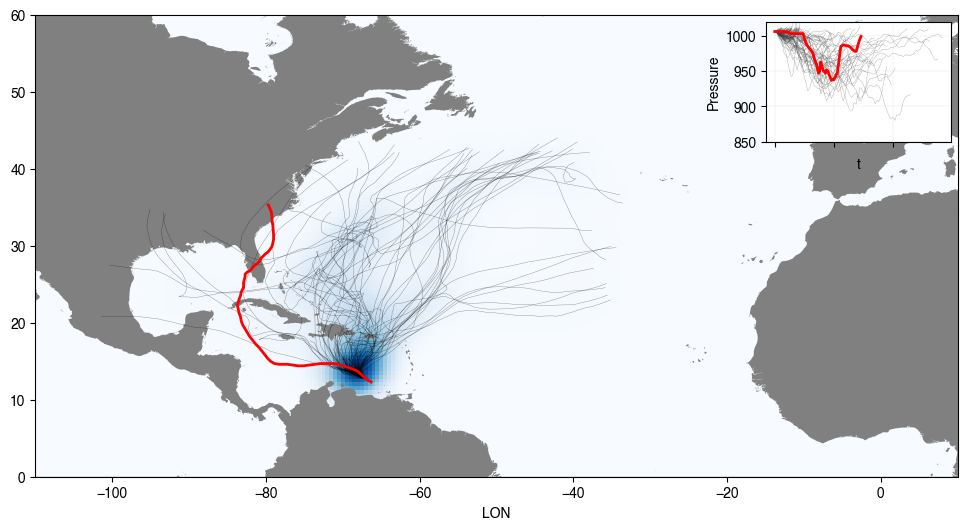

In [17]:
tracks_df = tr.resimulate(sid, basin, enso=2, m=m)
fig = tr.plot_tracks(tracks_df, basin, sid=sid, figsize=(12,6))

#### Resimulate under a strong La Nina counterfactual

  0%|          | 0/318 [00:00<?, ?it/s]

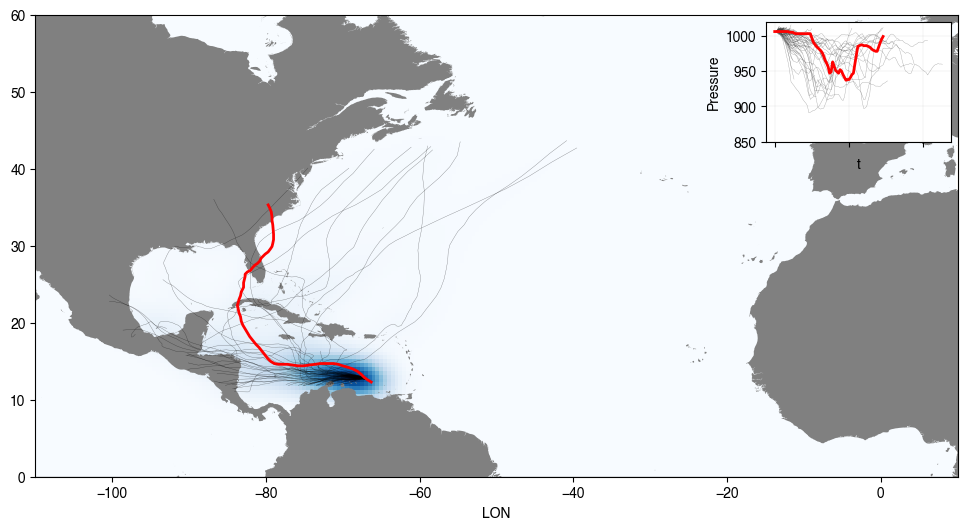

In [18]:
tracks_df = tr.resimulate(sid, basin, enso=-2, m=m)
fig = tr.plot_tracks(tracks_df, basin, sid=sid, figsize=(12,6))

#### Resimulate under 2024 SSTs counterfactual

  0%|          | 0/318 [00:00<?, ?it/s]

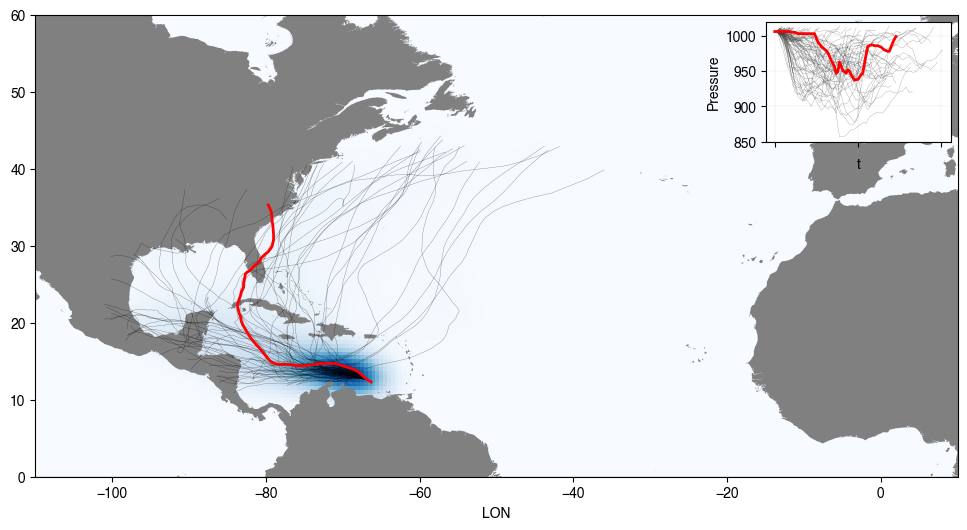

In [19]:
tracks_df = tr.resimulate(sid, basin, ssts=tr.ssts.sel(year=2024, month=month), m=m)
fig = tr.plot_tracks(tracks_df, basin, sid=sid, figsize=(12,6))